In [9]:
from prophet import Prophet
import pandas as pd
import pandas_gbq
import os 
import yaml

from datetime import date

In [2]:
project_id = 'ferrous-weaver-306014'

In [3]:
query = """
select
    date(date(creation_datetime)) as ds,
    count(distinct ID) as y
from
    `clinical_reporting_pipeline.inbound_referrals`
where
    client is not null
    and ID is not null
    and client = 'Conviva'
    and date(creation_datetime) >= '2025-04-01'
group by all
order by
    DS desc
"""

In [5]:
df = pandas_gbq.read_gbq(query, project_id=project_id)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [6]:
df.head()

,ds,y
0,2025-06-12,21
1,2025-06-11,15
2,2025-06-10,8
3,2025-06-09,9
4,2025-06-06,10


In [7]:
m = Prophet()
m.fit(df)

11:56:51 - cmdstanpy - INFO - Chain [1] start processing
11:56:51 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
future = m.make_future_dataframe(periods=252)
future.tail()

,ds
300,2026-02-15
301,2026-02-16
302,2026-02-17
303,2026-02-18
304,2026-02-19


In [9]:
forecast = m.predict(future)

In [10]:
forecast["run_date"] = pd.to_datetime(date.today())

In [11]:
df_out = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper','run_date']]
df_out.head()

,ds,yhat,yhat_lower,yhat_upper,run_date
0,2025-04-01,10.432162,5.337085,15.352486,2025-06-13
1,2025-04-02,14.622959,9.491172,19.678399,2025-06-13
2,2025-04-03,11.342904,6.004058,16.179318,2025-06-13
3,2025-04-04,10.452117,5.348686,16.028026,2025-06-13
4,2025-04-07,10.896709,5.915729,16.171671,2025-06-13


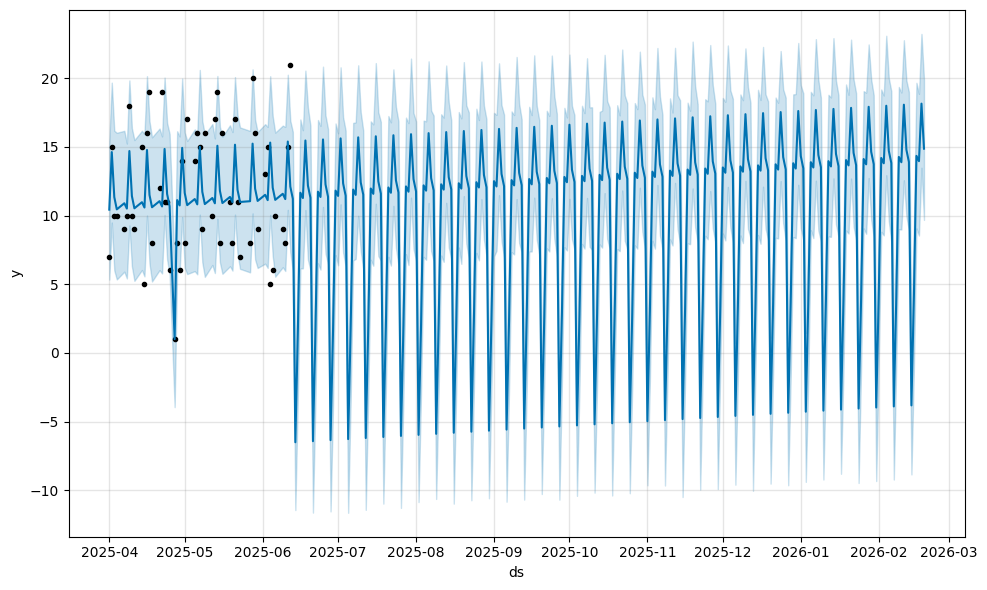

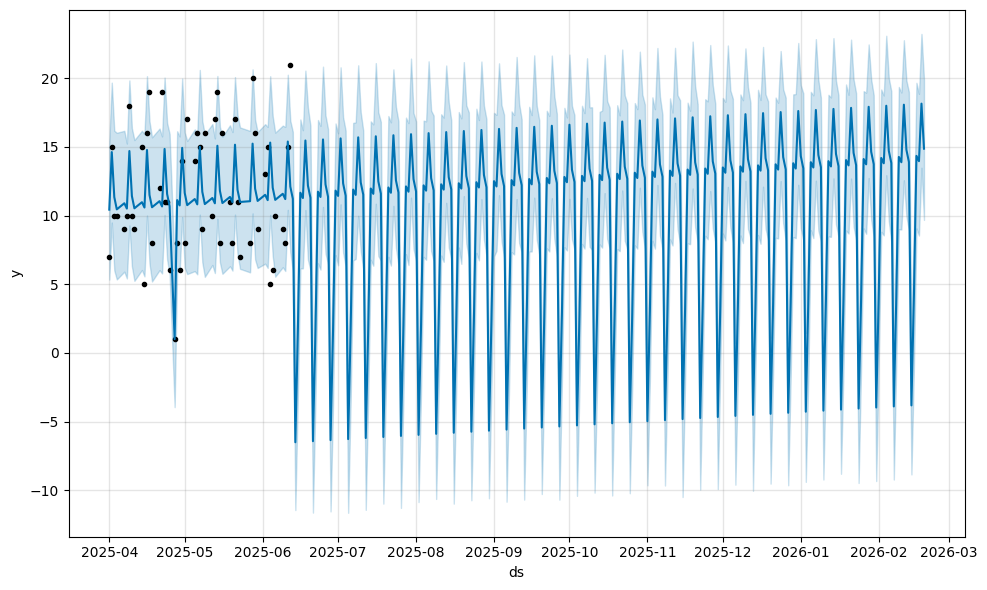

In [12]:
fig2 = m.plot(forecast)
fig2

In [55]:
pandas_gbq.to_gbq(
    df_out, 
    destination_table="capacity_plan.prophet_run",
    project_id=project_id,
    if_exists="replace"
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]
